In [1]:
# import necessary libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams.update({'font.size': 22})

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [4]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [5]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          650 non-null    object 
 1   Daily Confirmed                               650 non-null    int64  
 2   False Positives Found                         541 non-null    float64
 3   Cumulative Confirmed                          650 non-null    int64  
 4   Daily Discharged                              650 non-null    int64  
 5   Passed but not due to COVID                   650 non-null    int64  
 6   Cumulative Discharged                         650 non-null    int64  
 7   Discharged to Isolation                       650 non-null    int64  
 8   Still Hospitalised                            650 non-null    int64  
 9   Daily Deaths                                  650 non-null    int

In [7]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [8]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [9]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [10]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [11]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [12]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [13]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               650 non-null    int64  
 1   False Positives Found                         650 non-null    float64
 2   Cumulative Confirmed                          650 non-null    int64  
 3   Daily Discharged                              650 non-null    int64  
 4   Passed but not due to COVID                   650 non-null    int64  
 5   Cumulative Discharged                         650 non-null    int64  
 6   Discharged to Isolation                       650 non-null    int64  
 7   Still Hospitalised                            650 non-null    int64  
 8   Daily Deaths                                  650 non-null    int64  
 9   Cumulative Deaths                             650 non-null    int

<AxesSubplot:>

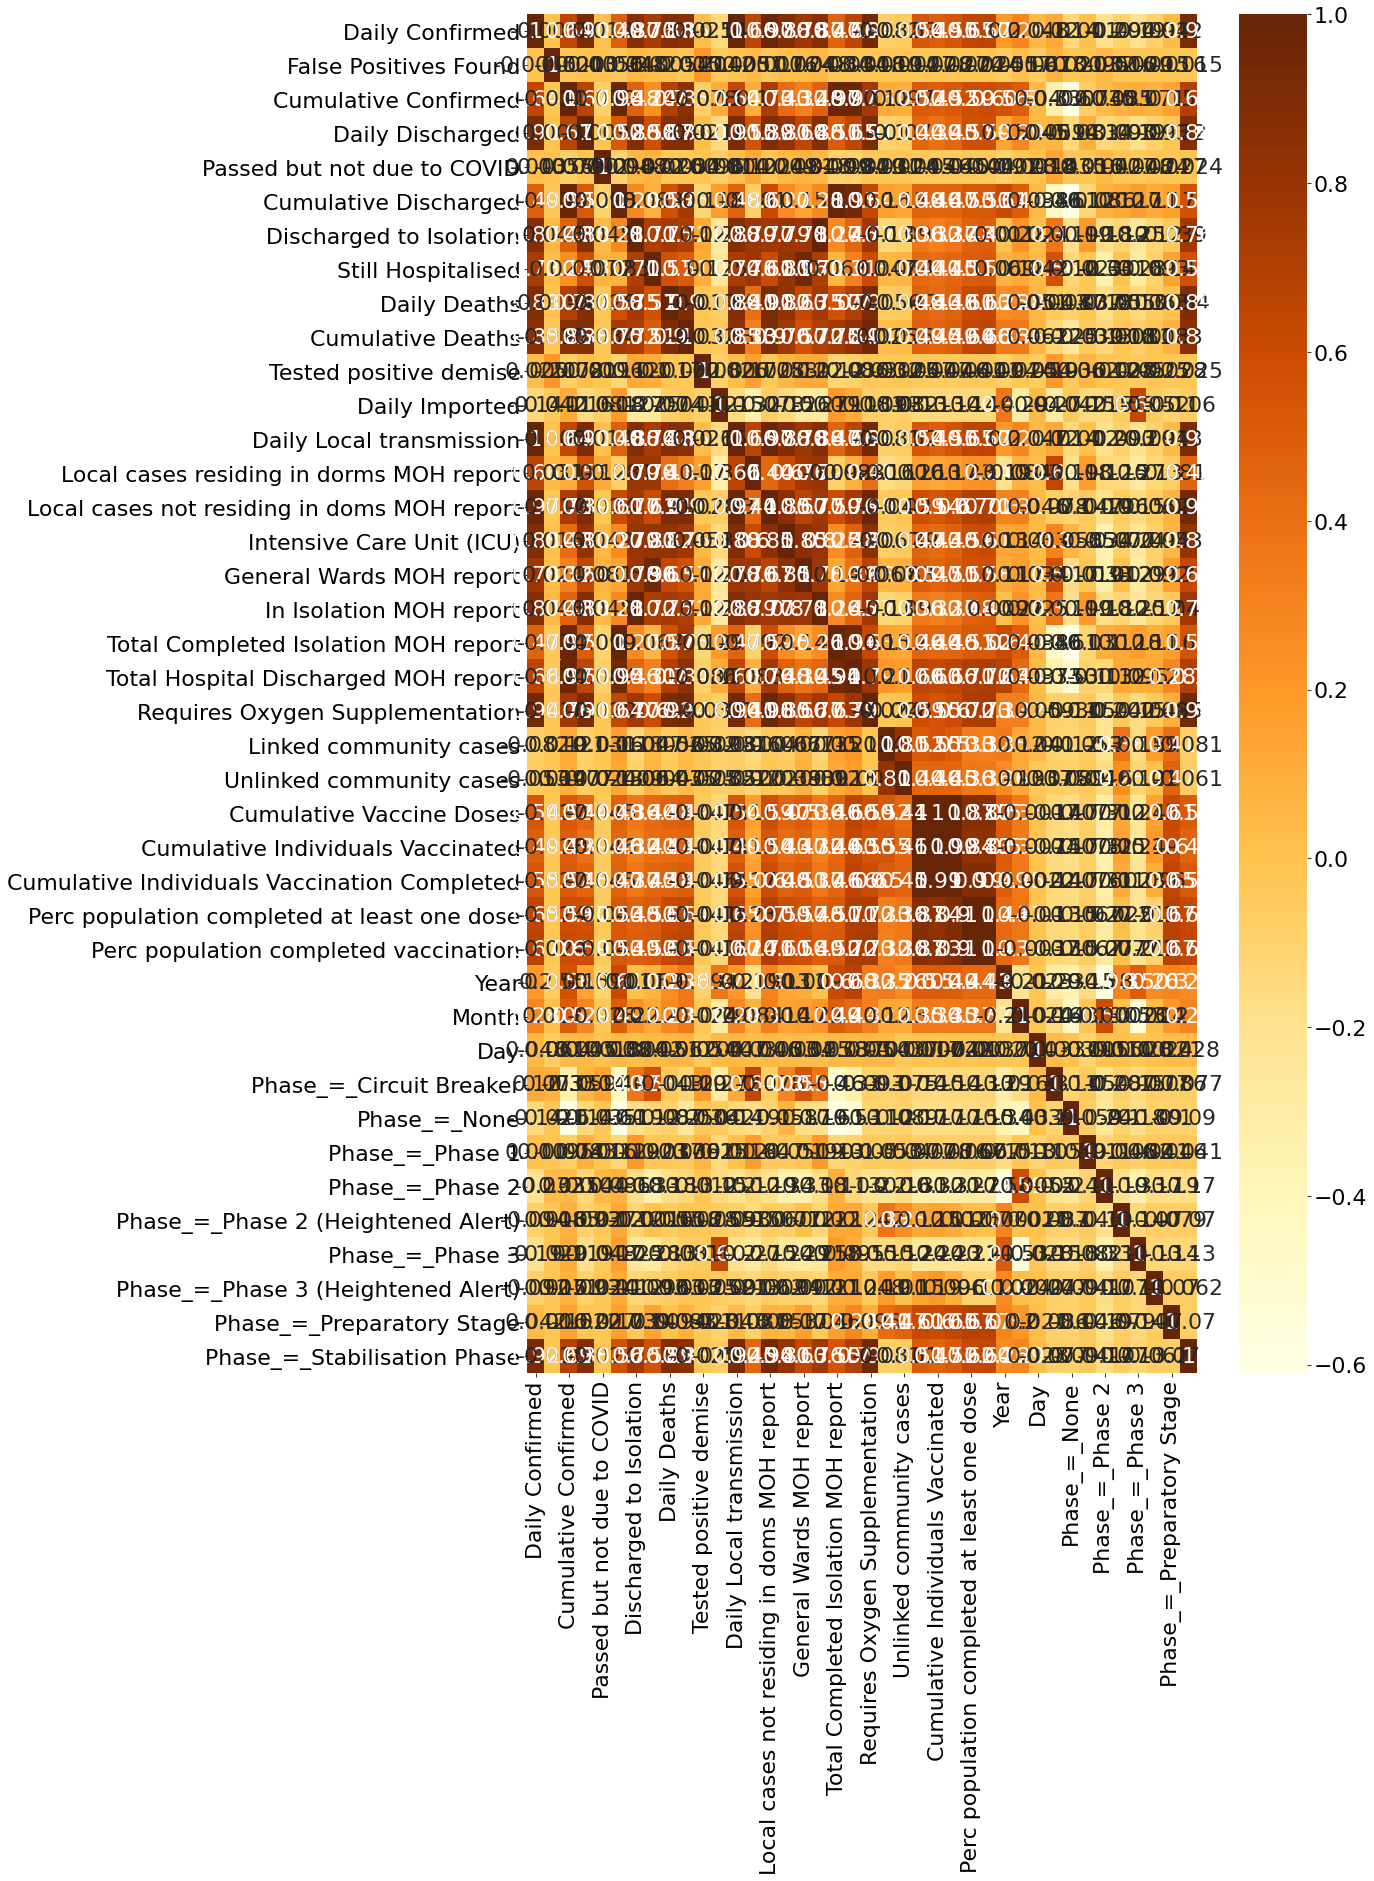

In [14]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [15]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Daily Confirmed"].sort_values(ascending=False)

Daily Confirmed                                 1.000000
Daily Local transmission                        0.999927
Local cases not residing in doms MOH report     0.966014
Requires Oxygen Supplementation                 0.939211
Phase_=_Stabilisation Phase                     0.919942
Daily Discharged                                0.909284
Intensive Care Unit (ICU)                       0.883343
Daily Deaths                                    0.879478
In Isolation MOH report                         0.874850
Discharged to Isolation                         0.873520
Cumulative Deaths                               0.848718
General Wards MOH report                        0.778934
Still Hospitalised                              0.734003
Perc population completed vaccination           0.666124
Total Hospital Discharged MOH report            0.660961
Local cases residing in dorms MOH report        0.658448
Perc population completed at least one dose     0.647478
Cumulative Confirmed           

In [16]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [17]:
# pca.components_[0]

In [18]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [19]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Viewing Chart Pattern

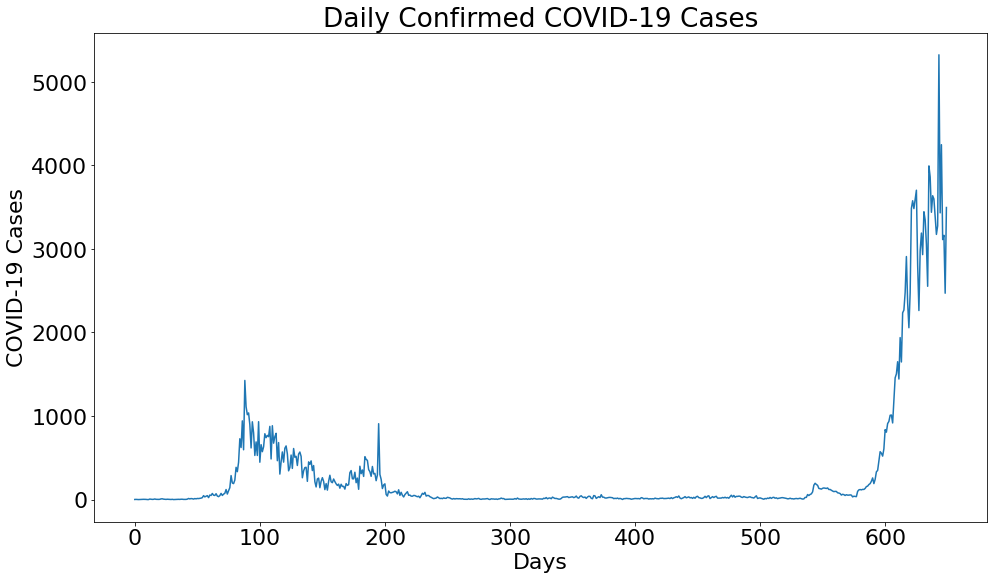

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Daily Confirmed"].plot()
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()
#fig.savefig('Daily_Confirmed_COVID-19_Cases.png')

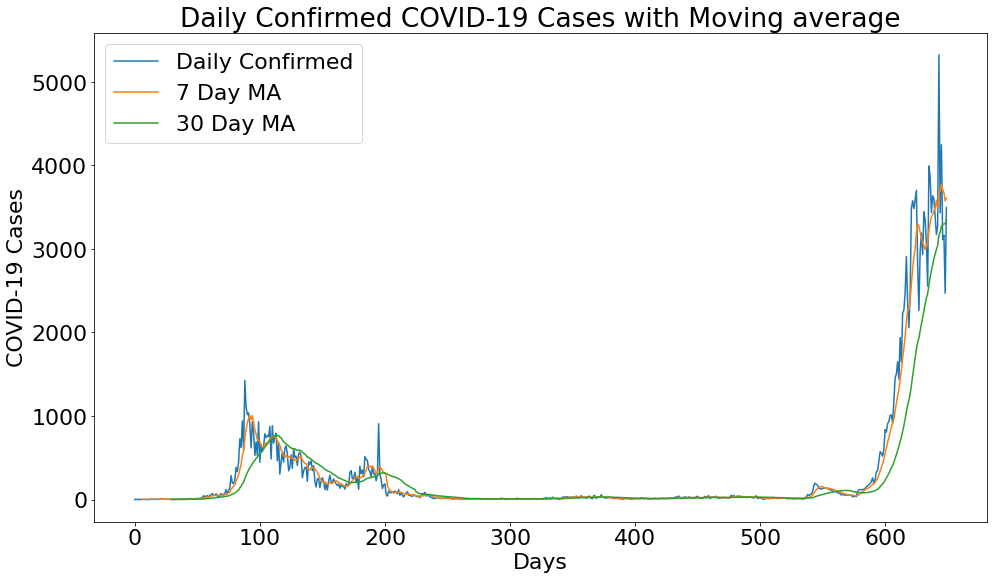

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Daily Confirmed"], label="Daily Confirmed")
ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Daily Confirmed COVID-19 Cases with Moving average')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()
#fig.savefig('Daily_Confirmed_COVID-19_Cases_with_Moving_average.png')

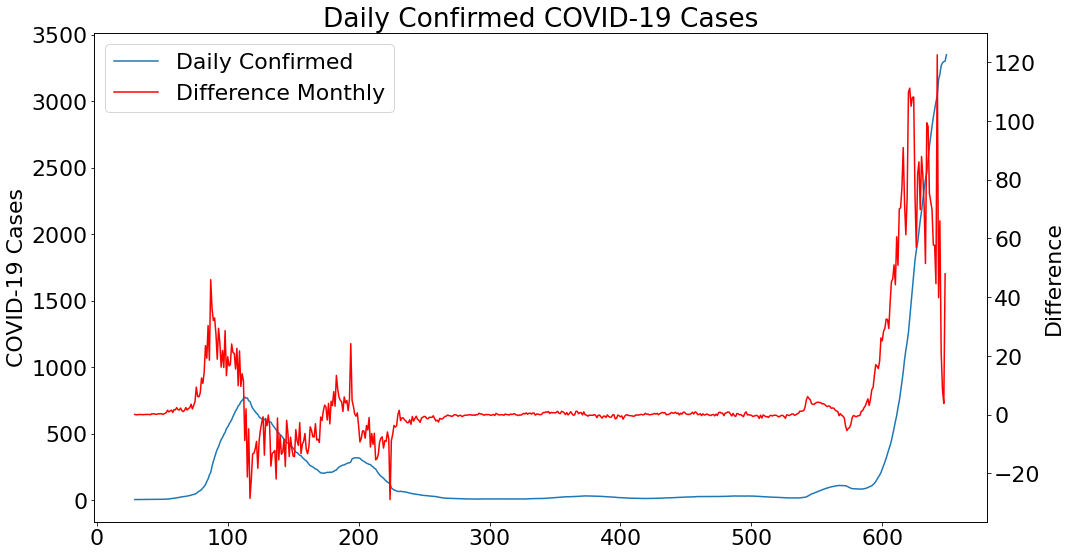

In [22]:
# shows inflection point
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean(), label="Daily Confirmed")
ax.set_ylabel("COVID-19 Cases")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean()), label="Difference Monthly",color='red')
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1+ln2)])
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.show()
#fig.savefig('Daily_Confirmed_COVID-19_Cases_diff.png')

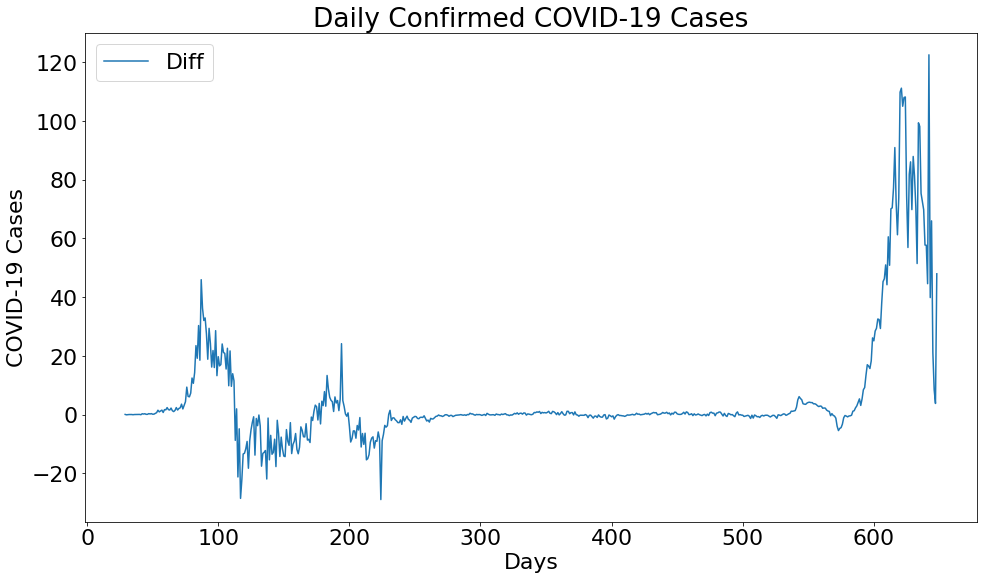

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.diff(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean()), label="Diff")
ax.legend()
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()


# Train Test Split & KFold Cross Validation

In [24]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Daily Confirmed", axis=1)
y = sg_data_filtered["Daily Confirmed"]

In [25]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:

# strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression

In [27]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [28]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 1.268353102514875e-10
MSE: 5.298901168722348e-20
RMSE: 2.3019342233700657e-10
R-squared score for train: 1.0
Adjusted R-squared score for train: 1.0
R-squared score for test: 1.0
Adjusted R-squared score for test: 1.0
Cross Validation Score: 1.0


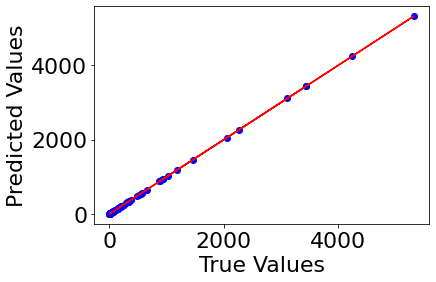

In [29]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

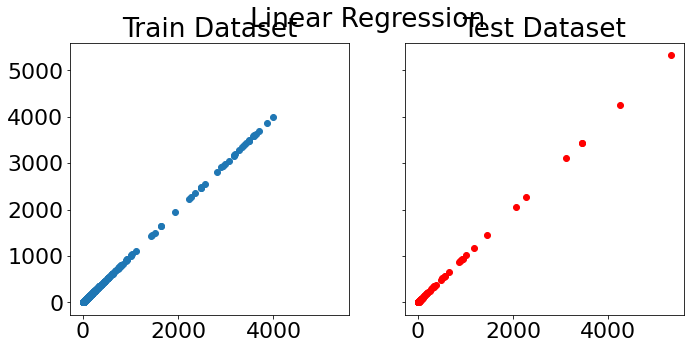

In [30]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [31]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
10,Daily Imported,1.000000e+00
11,Daily Local transmission,1.000000e+00
3,Passed but not due to COVID,1.211092e-09
9,Tested positive demise,3.155726e-10
1,Cumulative Confirmed,1.031286e-10
13,Local cases not residing in doms MOH report,1.064895e-11
12,Local cases residing in dorms MOH report,1.042335e-11
15,General Wards MOH report,3.123613e-12
16,In Isolation MOH report,2.885291e-12
25,Perc population completed at least one dose,2.249645e-12


# Ridge Regression

In [32]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.02354e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [33]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.02354e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.36443e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.90817e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Evaluation Metrics for Ridge
MAE: 0.00044614561628382346
MSE: 1.9966424043654034e-06
RMSE: 0.0014130259744128569
R-squared score for train: 0.9999999999983636
Adjusted R-squared score for train: 0.9999999999982591
R-squared score for test: 0.9999999999970245
Adjusted R-squared score for test: 0.9999999999968342
Cross Validation Score: 1.0


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.24397e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.08109e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


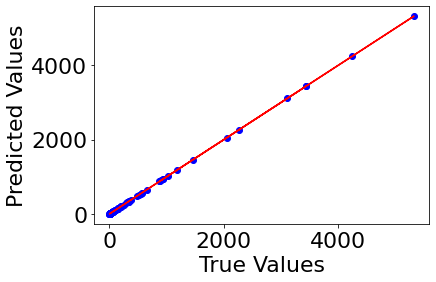

In [34]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

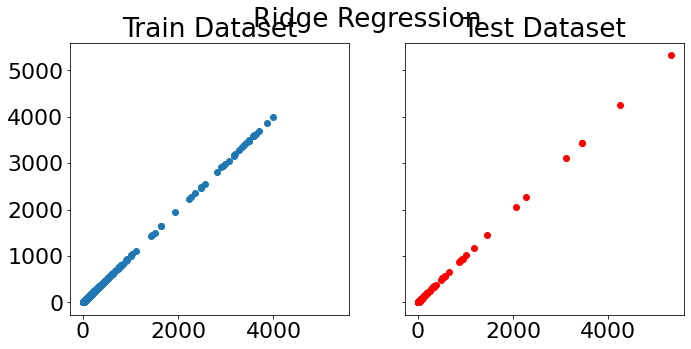

In [35]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [36]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
10,Daily Imported,9.999904e-01
11,Daily Local transmission,9.995342e-01
31,Phase_=_None,1.827953e-03
27,Year,5.999303e-04
13,Local cases not residing in doms MOH report,4.657090e-04
12,Local cases residing in dorms MOH report,4.652271e-04
1,Cumulative Confirmed,1.752173e-04
35,Phase_=_Phase 3,1.500834e-04
28,Month,8.289339e-05
14,Intensive Care Unit (ICU),6.171439e-05


# Important Features & Future Prediction

In [37]:
important_X = X[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [38]:
# training the model based on the few features extracted
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [39]:
# evaluating the new model with few select features
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.00023506445965866264
MSE: 1.479525401786247e-07
RMSE: 0.0003846459933219436
R-squared score for train: 0.9999999999998423
Adjusted R-squared score for train: 0.9999999999998389
R-squared score for test: 0.9999999999997795
Adjusted R-squared score for test: 0.9999999999997746
Cross Validation Score: 1.0


# XGBoost

In [59]:
# XGBoost

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.7,
 'min_child_weight': 6,
 'max_depth': 8,
 'colsample_bytree': 0.9}

In [60]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.7, max_depth=8, colsample_bytree=0.9, min_child_weight=6)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 21.995532355400233
MSE: 22988.101968916442
RMSE: 151.61827715983466
R-squared score for train: 0.9995808308752868
Adjusted R-squared score for train: 0.9995715893512774
R-squared score for test: 0.9657416724028887
Adjusted R-squared score for test: 0.9649863706920863
Cross Validation Score: 0.992


# Prediction with XGBoost

In [79]:
future_prediction = pd.DataFrame(data={
    "Daily Imported":[0],
    "Daily Local transmission":[5000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)

xgb_fut_pred
# total cases in SG of 3720 but does not make sense because daily local transmission is 5000
# no worries bout the numbers because there were only a few days of 5k cases

array([3676.3333], dtype=float32)

# XGBoost Without Daily Local Transmission

In [54]:
important_X_wo = X[["Daily Imported","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train_wo = X_train[["Daily Imported","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test_wo = X_test[["Daily Imported","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [55]:
# XGBoost

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X_wo, y)
xgb_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 4,
 'max_depth': 8,
 'colsample_bytree': 0.8}

In [56]:
xgb2 = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.8, max_depth=8, colsample_bytree=0.8, min_child_weight=4)
xgb2.fit(important_X_train_wo, y_train)
xgb_pred_wo = xgb2.predict(important_X_test_wo)
train_adjusted_r2_wo = 1 - (1-xgb2.score(important_X_train_wo, y_train)) * (len(y)-1)/(len(y)-important_X_wo.shape[1]-1)
test_adjusted_r2_wo = 1 - (1-xgb2.score(important_X_test_wo, y_test)) * (len(y)-1)/(len(y)-important_X_wo.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred_wo)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred_wo)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred_wo))}")
print(f"R-squared score for train: {xgb2.score(important_X_train_wo, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2_wo}")
print(f"R-squared score for test: {xgb2.score(important_X_test_wo, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2_wo}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb2, important_X_wo, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 73.18819313622438
MSE: 49861.754041429966
RMSE: 223.29745641504735
R-squared score for train: 0.993518321401579
Adjusted R-squared score for train: 0.9933858342604164
R-squared score for test: 0.9256928515965506
Adjusted R-squared score for test: 0.9241739947895619
Cross Validation Score: 0.9541


In [58]:
future_prediction_wo = pd.DataFrame(data={
    "Daily Imported":[12],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred_wo = xgb2.predict(future_prediction_wo)

xgb_fut_pred_wo

array([3137.9373], dtype=float32)